<a href="https://colab.research.google.com/github/JeFFich/Data_analysis/blob/main/%D0%A4%D0%B0%D0%BA%D1%82%D0%BE%D1%80%D0%BD%D1%8B%D0%B9_%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import factor_analyzer as fa
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from numpy import cumsum

In [ ]:
df = pd.read_csv('/content/sample_data/california_housing_train.csv')
pd.options.display.float_format = '{:,.3f}'.format # Лучше использовать для избавления от научной нотации при выводе

In [ ]:
df.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.310,34.190,15.000,"5,612.000","1,283.000","1,015.000",472.000,1.494,"66,900.000"
1,-114.470,34.400,19.000,"7,650.000","1,901.000","1,129.000",463.000,1.820,"80,100.000"
2,-114.560,33.690,17.000,720.000,174.000,333.000,117.000,1.651,"85,700.000"
3,-114.570,33.640,14.000,"1,501.000",337.000,515.000,226.000,3.192,"73,400.000"
4,-114.570,33.570,20.000,"1,454.000",326.000,624.000,262.000,1.925,"65,500.000"


В данном датасете представлены данные по домам в Калифорнии. Всего имеется девять столбцов со следующей информацией:


*   **longtitude** - координата дома по долготе
*   **latitude** - координата дома по широте
*   **housing_median_age** - усредненный возраст дома
*   **total_rooms** - общее кол-во комнат в доме
*   **total_bedrooms** - общее кол-во спален в доме
*   **population** - общее кол-во жильцов в доме
*   **households** - общее кол-во домохозяйств (семей)
*   **median_income** - медианный доход домохозяйств за год (в 10т долл.)
*   **median_house_value** - медианная стоимость квартиры в доме (в 1т долл.)


# Первичный анализ и оценка применимости факторного анализа

In [ ]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,"17,000.000","17,000.000","17,000.000","17,000.000","17,000.000","17,000.000","17,000.000","17,000.000","17,000.000"
mean,-119.562,35.625,28.589,"2,643.664",539.411,"1,429.574",501.222,3.884,"207,300.912"
std,2.005,2.137,12.587,"2,179.947",421.499,"1,147.853",384.521,1.908,"115,983.764"
min,-124.350,32.540,1.000,2.000,1.000,3.000,1.000,0.500,"14,999.000"
25%,-121.790,33.930,18.000,"1,462.000",297.000,790.000,282.000,2.566,"119,400.000"
50%,-118.490,34.250,29.000,"2,127.000",434.000,"1,167.000",409.000,3.545,"180,400.000"
75%,-118.000,37.720,37.000,"3,151.250",648.250,"1,721.000",605.250,4.767,"265,000.000"
max,-114.310,41.950,52.000,"37,937.000","6,445.000","35,682.000","6,082.000",15.000,"500,001.000"


Описательная статистика уже позволяет делать много различных выводов. Приведем некоторые из них:



*   Отклонение показателей *широты и долготы* **не очень велико**. Это демонстрирует компактность анализируемого региона
*   В данном регионе **большое кол-во относительно старых домов**: 75% домов из выборки старше 18 лет, а 50% - старше 29
*   В данном регионе **не очень распространен сектор частных домов**: так, явно более 75% всех домов являются многоквартирными (о чем можно судить по кол-ву комнат, проживающих и домохозяйств); при этом минимальные значения явно свидетельствуют о наличии в выборке одиночных домов
*   Стоит отметить и **наличие аномальных выбросов** у показателей *общего числа комнат, спален, проживающих людей и домохозяйств*: так в выборке имеются примеры превышения средней величины более чем в 10 раз по каждому признаку
*   В исследуемом регионе явно наблюдается **серьезная сегрегация людей по заработку**: так размах выборки по данному призанку составляют 14 500 (что эквивалентно разнице в годовой зарплате = 145 000 долл.); >50% зарабатывает меньше среднего показателя, а беднейшие 25% зарабатывает вообще лишь половину от среднего показателя зарплаты

При первичном анализе данных было выявлено явное отсутствие нормальности распределения признаков, из-за чего будем использовать коэффициент Спирмана

In [ ]:
df.corr(method='spearman')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000,-0.879,-0.156,0.043,0.067,0.127,0.065,-0.010,-0.070
latitude,-0.879,1.000,0.036,-0.022,-0.060,-0.127,-0.079,-0.090,-0.168
housing_median_age,-0.156,0.036,1.000,-0.357,-0.308,-0.286,-0.282,-0.143,0.076
total_rooms,0.043,-0.022,-0.357,1.000,0.914,0.816,0.906,0.267,0.204
total_bedrooms,0.067,-0.060,-0.308,0.914,1.000,0.873,0.976,-0.013,0.083
population,0.127,-0.127,-0.286,0.816,0.873,1.000,0.905,-0.002,-0.001
households,0.065,-0.079,-0.282,0.906,0.976,0.905,1.000,0.023,0.109
median_income,-0.010,-0.090,-0.143,0.267,-0.013,-0.002,0.023,1.000,0.681
median_house_value,-0.070,-0.168,0.076,0.204,0.083,-0.001,0.109,0.681,1.000


Исходя из полученных значений, можно сделать следующие выводы:



1. Показатели *общего числа комнат, спален, жителей и домохозяйств* имеют **достаточно сильные попарные связи**; это, однако, естественным образом согласуется со здравым смыслом: очевидно, например, что чем больше комнат в жилом доме, тем больше и будет среди них спален (в данном случае мы не рассматриваем дома "элитарного" класса, где такая связь ослабевает)
2. **Столь же очевидная связь** имеется и между показателями *среднегодового заработка и средней стоимости квартиры* (хотя стпень у нее уже не столь ярко выражена)
3. **Не стоит придавать значения сильной связи между широтой и долготой**; это всего лишь демонстрация компактности данной статистики (то есть дома не разбросаны на большой территории); данный факт лишь способствует локализации всевозможных выводов на относительно небольшой регион
4. Примечательно и **наличие обратной связи** между *средним возрастом дома* и его *"жилыми" характеристиками* (см. пункт 1) - чем старше дом, тем меньше его вместимость (то есть меньше комнат, спален, и, как следствие, меньше жильцов и домохозяйств); тем не менее, такая связь носит слабый характер
5. Несколько неожиданным можно отметить **отсутствие выраженной связи** между *общим числом комнат* и *среднегодовым заработком/средней ценой квартиры*; этот факт может свидетельствовать о "неэкстенсивном" уклоне дорогих домов в данном регионе (то есть фокусирование не на размер предлагаемых квартир, а на другие характеристики, вроде общей экологичности или технологичности)

Остальные признаки не демонстрируют какой-либо явной связи



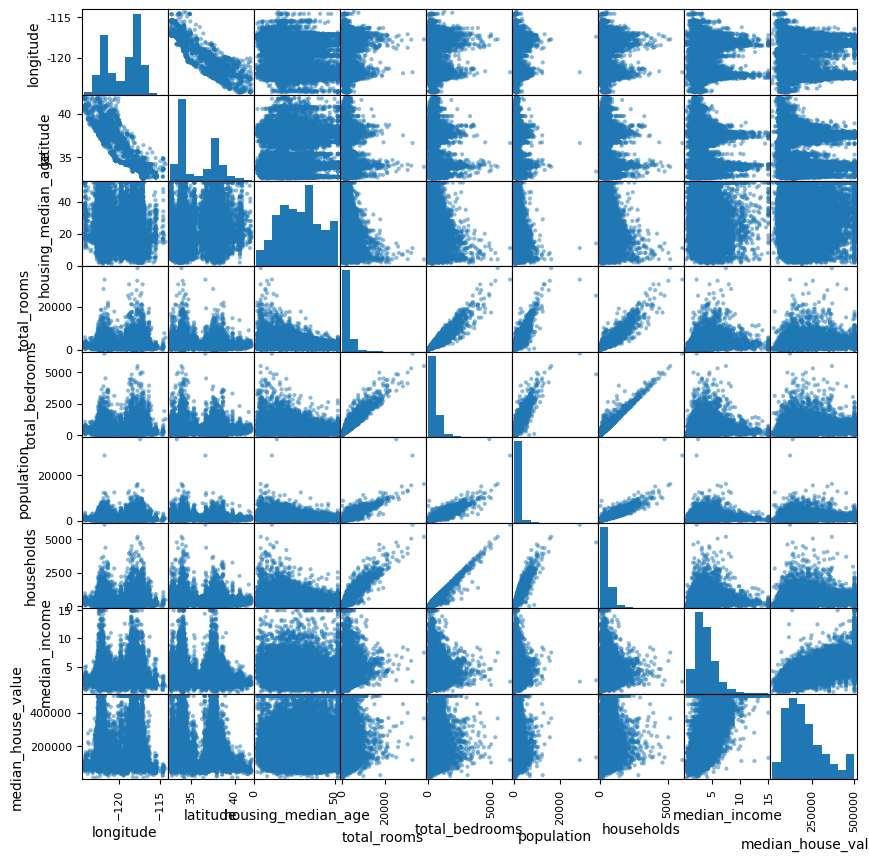

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(10,10))

plt.show()

На диаграмме **явно вырисывается линейная связь** между "характеристиками" дома; что-то более-менее линейное можно рассмотреть и в связи *двух последних показателей*. В остальных случаях диаграммы **не демонстрируют какой либо выраженной связи признаков**

При помощи критериев ***сферичности Баттлера*** и ***КМО*** сделаем вывод о применимости факторного анализа

In [ ]:
fa.factor_analyzer.calculate_bartlett_sphericity(df)

(185396.58105290975, 0.0)

*Значение p-уровня явно меньше 0.05*, следовательно имеются признаки с достаточно сильной корреляцией, а значит **применение факторного анализа целесообразно**

In [ ]:
kmo_all, kmo_model = fa.factor_analyzer.calculate_kmo(df)

In [ ]:
kmo_model

0.6584672486727183

Полученный kmo_model > 0.5, следовательно данные **подходят для факторного анализа** (при этом по классификации Крайзера полученный результат относится к *средним*, что не сулит высокую степень адекватности результатов факторного анализа)

# Выделение первичных факторов методом главных компонент

Произведем стандартизацию данных

In [ ]:
new_df = scale(df)

Реализуем метод главных компонент по отстандартизованным данным

In [ ]:
pca = PCA(n_components=9)

In [ ]:
pca.fit(new_df)

PCA(n_components=9)

Воспользуемся ***критерием Крайзера***, ***методом Кеттелла*** и ***критерием на основе суммарной доли объясненной дисперсии*** для выявления *числа факторов*

In [ ]:
eigen_values = pca.explained_variance_

In [ ]:
eigen_values

array([3.91679324, 1.92286771, 1.70169885, 0.90953546, 0.29044205,
       0.13861402, 0.06224336, 0.04413502, 0.01419974])

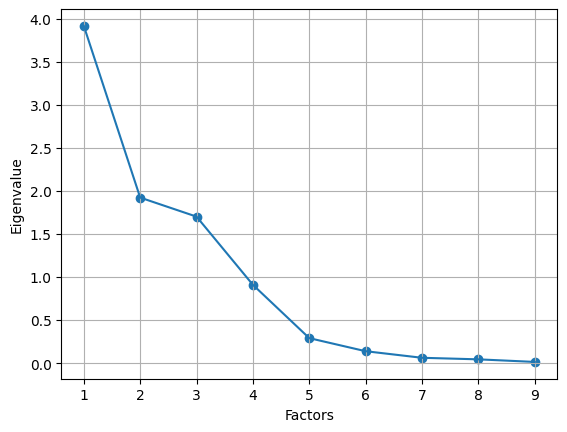

In [ ]:
plt.scatter(range(1,new_df.shape[1]+1),eigen_values)
plt.plot(range(1,new_df.shape[1]+1),eigen_values)
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()

plt.show()

In [ ]:
cumsum(pca.explained_variance_ratio_)

array([0.43517365, 0.64881305, 0.83787958, 0.93893313, 0.97120257,
       0.98660322, 0.99351874, 0.99842234, 1.        ])

По результатам всех критериев можно сказать, что нужно взять **3-4 фактора**

# Факторный анализ

## Факторный анализ для **3 компонент**

In [ ]:
FA = fa.FactorAnalyzer(n_factors= 3, rotation='varimax')

In [ ]:
FA.fit(new_df)

FactorAnalyzer(rotation='varimax', rotation_kwargs={})

In [ ]:
res1 = pd.DataFrame(FA.loadings_, columns=["Factor 1", "Factor 2", "Factor 3"], index = df.columns)

res1

,Factor 1,Factor 2,Factor 3
longitude,0.059,0.994,-0.063
latitude,-0.049,-0.934,-0.110
housing_median_age,-0.335,-0.049,0.012
total_rooms,0.949,-0.011,0.169
total_bedrooms,0.980,0.018,-0.000
population,0.910,0.060,-0.038
households,0.985,0.014,0.019
median_income,0.028,0.016,0.779
median_house_value,0.011,0.027,0.888


Дадим некоторую интерпретацию полученным факторам:


*   **Factor 1** - объединяет различные характеристики дома: общее число комнат, спален, количество жильцов и домохозяйств; по смысловому характеру данный фактор можно обозначить ***коммунальной характеристикой дома***
*   **Factor 2** - объединяет широту и долготу; по смысловому характеру данный фактор можно обозначить ***географическим положением***
*   **Factor 3** - объединяет показатели медианной цены квартиры и медианного дохода домохозяйств; по смысловому характеру данный фактор можно обозначить ***статусностью жилья***  

При этом стоит отметить, что показатель усредненного возраста дома **не относится явно ни к одному из выделенных факторов**, что следует учитывать при построении моделей на их основе

## Факторный анализ для **4 компонент**

In [ ]:
FA_extr = fa.FactorAnalyzer(n_factors=4, rotation='varimax')

In [ ]:
FA_extr.fit(new_df)

FactorAnalyzer(n_factors=4, rotation='varimax', rotation_kwargs={})

In [ ]:
res2 = pd.DataFrame(FA_extr.loadings_, columns=["Factor 1", "Factor 2", "Factor 3", "Factor 4"], index = df.columns)

res2

,Factor 1,Factor 2,Factor 3,Factor 4
longitude,0.025,0.953,-0.058,0.136
latitude,-0.054,-0.985,-0.102,0.071
housing_median_age,-0.265,-0.041,0.004,-0.455
total_rooms,0.916,-0.005,0.159,0.265
total_bedrooms,0.979,0.030,-0.011,0.104
population,0.893,0.069,-0.042,0.159
households,0.992,0.027,0.008,0.076
median_income,-0.021,0.005,0.900,0.274
median_house_value,0.073,0.038,0.855,-0.276


Как нетрудно заметить, введенная 4 компонента *не несёт в себе какой-либо цельной смысловой нагрузки*, соответственно **факторный анализ при 3 компонентах будет предпочтительнее**

## Исследование особенностей построенного факторного анализа для **3 компонент**

In [ ]:
FA.get_communalities()

array([0.99643458, 0.88638344, 0.11462131, 0.92890242, 0.96054861,
       0.83371466, 0.96994608, 0.60846095, 0.78915976])

In [ ]:
FA.get_uniquenesses()

array([0.00356542, 0.11361656, 0.88537869, 0.07109758, 0.03945139,
       0.16628534, 0.03005392, 0.39153905, 0.21084024])

По приведенным значениям видно, что полученные факторы, как этого и стоило ожидать, **плохо учитывают дисперсию показателя housing_median_age** (большая её часть приходится на *уникальную составляющую*); также н**есколько посредственно учитывается дисперсия медианного дохода**, так как порядка 40% приходится на *уникальную составляющую*; остальные показатели в целом имеют достаточно большую долю общности по факторам

In [ ]:
pd.DataFrame(FA.get_factor_variance(), columns=["Factor 1", "Factor 2", "Factor 3"], index=['SS Loadings', 'Proportion Var', 'Cumulative Var'])

,Factor 1,Factor 2,Factor 3
SS Loadings,3.777,1.869,1.442
Proportion Var,0.420,0.208,0.160
Cumulative Var,0.420,0.627,0.788


На полученные факторы приходится порядка *79% общей дисперсии наблюдений*, что говорит о, в целом, адекватности полученной факторизации

Рассчитаем значения наблюдений по каждому фактору и оценим корреляцию получившихся параметров

In [ ]:
factored_df = pd.DataFrame(FA.fit_transform(new_df),columns=["Factor 1", "Factor 2", "Factor 3"])

factored_df.head(5)

,Factor 1,Factor 2,Factor 3
0,0.709,2.216,-1.550
1,1.214,1.883,-1.688
2,-0.892,2.505,-1.243
3,-0.523,2.433,-1.163
4,-0.502,2.467,-1.339


In [ ]:
factored_df.corr()

,Factor 1,Factor 2,Factor 3
Factor 1,1.000,0.003,0.001
Factor 2,0.003,1.000,-0.012
Factor 3,0.001,-0.012,1.000


Полученные корреляции достаточно малы, что позволяет говорить о возможности применения факторов в регрессионном анализе